In [1]:
%load_ext autoreload
%autoreload 2

# get project dir
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

pp = PurePath(Path.cwd()).parts[:]
pdir = PurePath(*pp)
data_script_dir = pdir / 'src' / 'data'
bars_script_dir = pdir / 'src' / 'features'
sys.path.append(data_script_dir.as_posix())
sys.path.append(bars_script_dir.as_posix())
viz_dir = pdir / 'reports' / 'figures'
data_dir = pdir / 'data'

# import python scientific stack
import pandas as pd
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
# from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from utils import *
from bars import *

RANDOM_STATE = 777

print()

## Code Snippets

In [2]:
## Symmetric CUSUM Filter [2.5.2.1]

def getTEvents(gRaw, h):
    """
    Symmetric CUSUM Filter
    Sample a bar t iff S_t >= h at which point S_t is reset
    Multiple events are not triggered by gRaw hovering around a threshold level
    It will require a full run of length h for gRaw to trigger an event
    
    Two arguments:
        gRaw: the raw time series we wish to filter (gRaw)
        h: threshold
        
    Return:
        pd.DatatimeIndex.append(tEvents): 
    """
    
#    tEvents, sPos, sNeg = [], 0, 0
#    diff = gRaw.diff()
#    
#    for i in diff.index[1:]:
#        sPos, sNeg = max(0,sPos+diff.loc[i]), min(0,sNeg+diff.loc[i])
#        if sNeg < -h:
#            sNeg = 0; tEvents.append(i)
#        elif sPos > h:
#            sPos = 0; tEvents.append(i)
#    return pd.DatetimeIndex(tEvents)

    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)
            
    

In [3]:
## Daily Volatility Estimator [3.1]

def getDailyVol (close, span0 = 100):
    """
    Compute the daily volatility at intraday estimation
    applying a span of span0 to an exponentially weighted moving standard deviation
    
    Set profit taking and stop loss limits that are function of the risks involved in a bet
    """

    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [4]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0:
        pt=ptSl[0]*events_['trgt']
    else: 
        pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0:
        sl=-ptSl[1]*events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

In [5]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

In [6]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

In [7]:
def getBinsOld(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out

In [8]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

In [9]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [10]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [11]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

In [12]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

In [13]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

In [14]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

In [15]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

In [16]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
import copyreg,types, multiprocessing as mp
copyreg.pickle(types.MethodType,_pickle_method,_unpickle_method)

In [17]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)


In [18]:
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask      size         v            dv
2018-02-26 15:59:59  115.35  115.34  115.36     412.5     412.5  4.758188e+04
2018-02-26 16:00:00  115.35  115.34  115.35    5362.0    5362.0  6.185067e+05
2018-02-26 16:10:00  115.35  115.22  115.58       0.0       0.0  0.000000e+00
2018-02-26 16:16:14  115.30  114.72  115.62  778677.0  778677.0  8.978146e+07
2018-02-26 18:30:00  115.35  114.72  117.38       0.0       0.0  0.000000e+00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 941297 entries, 2009-09-28 09:30:00 to 2018-02-26 18:30:00
Data columns (total 6 columns):
price    941297 non-null float64
bid      941297 non-null float64
ask      941297 non-null float64
size     941297 non-null float64
v        941297 non-nul

## [3.1] Form Dollar Bars

In [19]:
dbars = dollar_bar_df(df,'dv',1_000_000).drop_duplicates().dropna()

In [20]:
cprint(dbars)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price         bid         ask           size  \
2018-02-26 15:31:06  115.29  115.280000  115.290000    2022.000000   
2018-02-26 15:40:15  115.41  115.400000  115.410000     723.000000   
2018-02-26 15:49:42  115.20  115.176667  115.186667    4487.166667   
2018-02-26 15:59:04  115.27  115.260000  115.270000     300.000000   
2018-02-26 16:16:14  115.30  114.720000  115.620000  778677.000000   

                                 v            dv  
2018-02-26 15:31:06    2022.000000  2.331164e+05  
2018-02-26 15:40:15     723.000000  8.344143e+04  
2018-02-26 15:49:42    4487.166667  5.171190e+05  
2018-02-26 15:59:04     300.000000  3.458100e+04  
2018-02-26 16:16:14  778677.000000  8.978146e+07  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Da

In [21]:
close = dbars.price.copy()
dailyVol = getDailyVol(close)

In [22]:
cprint(dailyVol.to_frame())

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     dailyVol
2018-02-26 15:31:06  0.006852
2018-02-26 15:40:15  0.006893
2018-02-26 15:49:42  0.006889
2018-02-26 15:59:04  0.006894
2018-02-26 16:16:14  0.006902
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30843 entries, 2009-09-29 10:03:18 to 2018-02-26 16:16:14
Data columns (total 1 columns):
dailyVol    30842 non-null float64
dtypes: float64(1)
memory usage: 481.9 KB
None
-------------------------------------------------------------------------------



In [23]:
close.to_excel('testClose.xlsx')

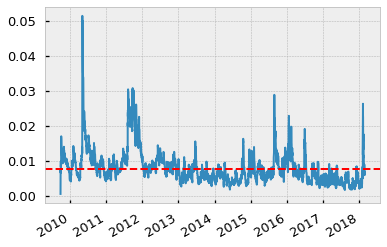

In [24]:
f, ax = plt.subplots()
dailyVol.plot(ax = ax)
ax.axhline(dailyVol.mean(),ls='--',color='red')

In [25]:
from tqdm import tqdm, tqdm_notebook

tEvents = getTEvents(close, h = dailyVol.mean())

100%|██████████████████████████████████| 30858/30858 [00:04<00:00, 7523.23it/s]


In [26]:
tEvents

DatetimeIndex(['2009-09-29 09:33:01', '2009-09-30 09:45:21',
               '2009-09-30 13:31:12', '2009-10-01 09:43:58',
               '2009-10-01 11:12:07', '2009-10-02 09:44:14',
               '2009-10-02 10:35:05', '2009-10-05 09:51:42',
               '2009-10-05 14:55:48', '2009-10-06 09:29:52',
               ...
               '2018-02-16 14:23:51', '2018-02-20 09:30:00',
               '2018-02-20 15:21:07', '2018-02-21 14:04:12',
               '2018-02-21 15:12:30', '2018-02-22 12:18:21',
               '2018-02-22 14:56:14', '2018-02-23 11:37:32',
               '2018-02-23 15:58:39', '2018-02-26 13:06:34'],
              dtype='datetime64[ns]', length=2278, freq=None)

## (b) Add Vertical barrier

In [27]:
t1 = addVerticalBarrier(tEvents,close)
t1

2009-09-29 09:33:01   2009-09-30 09:45:21
2009-09-30 09:45:21   2009-10-01 10:00:48
2009-09-30 13:31:12   2009-10-01 13:33:25
2009-10-01 09:43:58   2009-10-02 09:44:14
2009-10-01 11:12:07   2009-10-02 11:50:21
2009-10-02 09:44:14   2009-10-05 09:51:42
2009-10-02 10:35:05   2009-10-05 09:51:42
2009-10-05 09:51:42   2009-10-06 10:16:02
2009-10-05 14:55:48   2009-10-06 15:35:49
2009-10-06 09:29:52   2009-10-07 09:47:16
2009-10-06 11:32:02   2009-10-07 11:48:22
2009-10-06 14:07:37   2009-10-07 14:22:36
2009-10-08 09:29:51   2009-10-09 09:31:12
2009-10-12 09:31:02   2009-10-13 09:47:54
2009-10-13 10:52:10   2009-10-14 11:12:03
2009-10-14 09:29:52   2009-10-15 09:37:24
2009-10-14 15:30:48   2009-10-15 15:57:25
2009-10-16 09:55:03   2009-10-19 09:37:41
2009-10-16 15:40:15   2009-10-19 09:37:41
2009-10-19 11:39:38   2009-10-20 11:50:28
2009-10-20 11:50:28   2009-10-21 12:44:38
2009-10-21 10:11:57   2009-10-22 10:47:06
2009-10-21 15:32:09   2009-10-22 15:49:30
2009-10-22 09:55:51   2009-10-23 1

## (c) Apply Triple-barrier method where ptSl = [1,1], and t1 is the series created in 1.b

In [28]:
# create target series
ptSl = [1,1]
target = dailyVol

# select minRet
minRet = 0.01

# Run in single-threaded mode on Windows
import platform
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
    
events = getEvents(close,tEvents, ptSl, target, minRet, cpus, t1 = t1)

In [29]:
cprint(events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                                     t1      trgt
2018-02-13 13:43:37 2018-02-14 13:53:59  0.014365
2018-02-14 10:30:48 2018-02-15 09:31:56  0.012136
2018-02-14 13:36:02 2018-02-15 13:42:09  0.011688
2018-02-15 09:31:56 2018-02-16 09:42:36  0.011244
2018-02-15 14:05:41 2018-02-16 12:05:18  0.010183
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 929 entries, 2009-10-05 14:55:48 to 2018-02-15 14:05:41
Data columns (total 2 columns):
t1      929 non-null datetime64[ns]
trgt    929 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 61.8 KB
None
-------------------------------------------------------------------------------



## (d) Apply getBins to generate labels

In [30]:
labels = getBins(events, close)
cprint(labels)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-02-13 13:43:37  0.010108  1.0
2018-02-14 10:30:48  0.015045  1.0
2018-02-14 13:36:02  0.005056  1.0
2018-02-15 09:31:56  0.003964  1.0
2018-02-15 14:05:41  0.010431  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 929 entries, 2009-10-05 14:55:48 to 2018-02-15 14:05:41
Data columns (total 2 columns):
ret    929 non-null float64
bin    929 non-null float64
dtypes: float64(2)
memory usage: 61.8 KB
None
-------------------------------------------------------------------------------



In [31]:
labels.bin.value_counts()

 1.0    523
-1.0    406
Name: bin, dtype: int64

## [3.2] Use snippet 3.8 to drop under-populatyed labels

In [32]:
clean_labels = dropLabels(labels)
cprint(clean_labels)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2018-02-13 13:43:37  0.010108  1.0
2018-02-14 10:30:48  0.015045  1.0
2018-02-14 13:36:02  0.005056  1.0
2018-02-15 09:31:56  0.003964  1.0
2018-02-15 14:05:41  0.010431  1.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 929 entries, 2009-10-05 14:55:48 to 2018-02-15 14:05:41
Data columns (total 2 columns):
ret    929 non-null float64
bin    929 non-null float64
dtypes: float64(2)
memory usage: 61.8 KB
None
-------------------------------------------------------------------------------



## [3.4] Develop moving average crossover strategy. For each obs. The model suggests a side but not size of the bet

In [33]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price = close)
            .assign(fast  = close.ewm(fast_window).mean())
            .assign(slow  = close.ewm(slow_window).mean()))
cprint(close_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price        fast        slow
2018-02-26 15:31:06  115.29  115.227691  115.057569
2018-02-26 15:40:15  115.41  115.273268  115.101623
2018-02-26 15:49:42  115.20  115.254951  115.113920
2018-02-26 15:59:04  115.27  115.258713  115.133430
2018-02-26 16:16:14  115.30  115.269035  115.154251
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2009-09-28 09:53:49 to 2018-02-26 16:16:14
Data columns (total 3 columns):
price    30860 non-null float64
fast     30860 non-null float64
slow     30860 non-null float64
dtypes: float64(3)
memory usage: 964.4 KB
None
-------------------------------------------------------------------------------



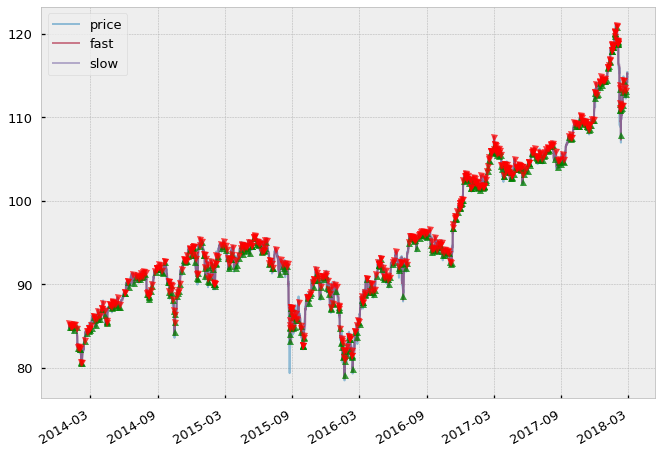

In [34]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1)&(crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.slow[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax,alpha=.5)
up.loc['2014':].plot(ax=ax,
                     ls='',
                     marker='^',
                     markersize=7,
                     alpha=.75,
                     label='upcross',
                     color = 'g')
down.loc['2014':].plot(ax=ax,
                     ls='',
                     marker='v',
                     markersize=7,
                     alpha=.75,
                     label='downcross',
                     color = 'r')


## (a) Derive meta-labels for ptSl = [1,2] and t1 where numdays = 1. Use as trgt dailyVol computed by snippet 3.1 (get events with sides)

In [35]:
# trading signal
side_up = pd.Series(1,index = up.index)
side_down = pd.Series(-1, index = down.index)
side = pd.concat([side_up, side_down]).sort_index()
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
2018-02-21 11:10:00  1
2018-02-21 15:12:30 -1
2018-02-22 11:48:39  1
2018-02-22 13:34:29 -1
2018-02-23 10:01:41  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1712 entries, 2009-09-30 09:45:21 to 2018-02-23 10:01:41
Data columns (total 1 columns):
0    1712 non-null int64
dtypes: int64(1)
memory usage: 26.8 KB
None
-------------------------------------------------------------------------------



In [36]:
minRet = .01
ptSl = [1,2]
ma_events = getEvents(close, tEvents, ptSl, target, minRet, cpus, t1 = t1, side = side)
cprint(ma_events)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2018-02-13 13:43:37   NaN 2018-02-14 13:53:59  0.014365
2018-02-14 10:30:48   NaN 2018-02-15 10:42:27  0.012136
2018-02-14 13:36:02   NaN 2018-02-15 13:42:09  0.011688
2018-02-15 09:31:56   NaN 2018-02-16 09:42:36  0.011244
2018-02-15 14:05:41   NaN 2018-02-16 14:15:08  0.010183
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 929 entries, 2009-10-05 14:55:48 to 2018-02-15 14:05:41
Data columns (total 3 columns):
side    102 non-null float64
t1      929 non-null datetime64[ns]
trgt    929 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 69.0 KB
None
-------------------------------------------------------------------------------



In [37]:
ma_events.side.value_counts()

 1.0    53
-1.0    49
Name: side, dtype: int64

In [38]:
ma_side= ma_events.dropna().side

In [39]:
ma_bins = getBins(ma_events,close).dropna()

In [40]:
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2016-07-07 14:28:00 -0.018703  0.0
2016-07-08 09:30:57  0.010571  1.0
2018-02-06 10:18:08 -0.026702  0.0
2018-02-07 15:28:09 -0.030792  0.0
2018-02-13 09:30:00 -0.001803  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2009-10-29 13:40:22 to 2018-02-13 09:30:00
Data columns (total 2 columns):
ret    102 non-null float64
bin    102 non-null float64
dtypes: float64(2)
memory usage: 2.4 KB
None
-------------------------------------------------------------------------------



In [41]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns = {0:'side'}),
                   left_index = True, right_index = True, direction = 'forward')

In [42]:
cprint(Xx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin  side
2016-07-07 14:28:00 -0.018703  0.0    -1
2016-07-08 09:30:57  0.010571  1.0     1
2018-02-06 10:18:08 -0.026702  0.0    -1
2018-02-07 15:28:09 -0.030792  0.0     1
2018-02-13 09:30:00 -0.001803  0.0    -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2009-10-29 13:40:22 to 2018-02-13 09:30:00
Data columns (total 3 columns):
ret     102 non-null float64
bin     102 non-null float64
side    102 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB
None
-------------------------------------------------------------------------------



In [43]:
Xx.ret.sum()

0.14388169456817856

## (b) Train Random Forest to decided whether to trade or not {0,1} since the undelying model (cross m.a) has decided the side, {-1,1}

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

C:\Users\rex.wong\AppData\Local\Continuum\anaconda3\envs\rex\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [45]:
X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values
pd.DataFrame(X,y)

,0
0.0,1.0
1.0,-1.0
1.0,-1.0
0.0,1.0
0.0,1.0
0.0,-1.0
0.0,1.0
1.0,1.0
1.0,-1.0
0.0,1.0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, shuffle = False)

In [51]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth = 2, n_estimators=n_estimator,
                            criterion = 'entropy', random_state = RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=777, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        24
        1.0       0.53      1.00      0.69        27

avg / total       0.28      0.53      0.37        51



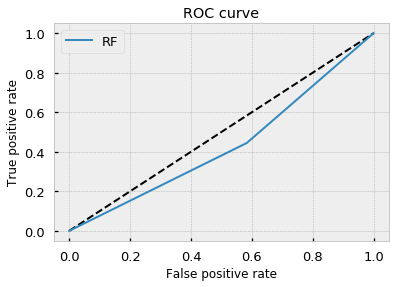

In [52]:
# The random forest model by itself

y_pred_rf = rf.predict_proba(X_test)[:,1]
y_pred = rf.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
      
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()